In [4]:
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib import animation

In [5]:
class particle():
    def __init__(self, position, direction):
        self.p = np.array(position) # 3D vector
        self.d = np.array(direction) # 3D vector
        self.m = 1
        self.dt = 0.25 # timestep, in seconds
        self.initrho = 1
        self.rho = 0
        self.pre = 0
        self.vmax = 10 # maximum velocity of particle
        self.a = np.array([0, 0, 0])
        self.g = np.array([0, 0, 9.81])
    
    def get_magnitude(self):
        return np.linalg.norm(self.p)
    
    def get_pos(self):
        return self.p
    
    def set_pos(self, new_pos):
        self.p = new_pos
    
print("Particle class built!")

Particle class built!


In [6]:
class particle_array():
    def __init__(self, n, dims, seed = 4):
        # Seed for generating pseudorandom particle positions
        self.seed = random.seed(seed)
        
        # Sets boundaries for the simulation
        self.xmin = dims[0]
        self.xmax = dims[1]
        self.ymin = dims[2]
        self.ymax = dims[3]
        self.zmin = dims[4]
        self.zmax = dims[5]
        
        # Generates particles with a random starting position
        pPositions = []
        for i in range(n):
            pPositions.append([
                random.uniform(self.xmax - 2, self.xmax - 1),
                random.uniform(self.ymax - 2, self.ymax - 1),
                random.uniform(self.zmax - 2, self.zmax - 1)
            ])    
        self.particles = [particle(pPositions[i], [0, 0, 0]) for i in range(n)]
        
        # Calculate initial density, pressure, acceleration, and velocity
        # based on the position of the other particles.
        self.calc_density()
        self.calc_pressure()
        self.calc_acc()
        self.calc_vel()
            
    # Equation (14) from https://pmocz.github.io/manuscripts/pmocz_sph.pdf
    def calc_acc(self):
        for p1 in self.particles:
            temp_acc = np.array([0,0,0], dtype = float)
            for p2 in self.particles:
                if id(p1) != id(p2):
                    temp_acc += p2.m * ((p1.pre / (p1.rho ** 2)) + (p2.pre / (p2.rho ** 2))) * (self.dgaus_kern(p1, p2))  
            p1.a=temp_acc
            
    def calc_vel(self):
        for p in self.particles:
            new_vel = p.d + (p.a * p.dt) - (p.g * p.dt)
            magnitude = np.linalg.norm(new_vel)
            if magnitude > p.vmax:
                new_vel = (p.vmax / magnitude) * new_vel
            p.d=new_vel

    def move(self):
        for p in self.particles:
            new_pos = p.get_pos() + (p.d * p.dt)
            if new_pos[0] < self.xmin:
                new_pos[0] = self.xmin
                p.d[0] *= -0.75
            if new_pos[0] > self.xmax:
                new_pos[0] = self.xmax
                p.d[0] *= -0.75
            if new_pos[1] < self.ymin:
                new_pos[1] = self.ymin
                p.d[1] *= -0.75
            if new_pos[1] > self.ymax:
                new_pos[1] = self.ymax
                p.d[1] *= -0.75
            if new_pos[2] < self.zmin:
                new_pos[2] = self.zmin
                p.d[2] *= -0.75
            if new_pos[2] > self.zmax:
                new_pos[2] = self.zmax
                p.d[2] *= -0.75
            p.set_pos(new_pos)
                           
    # Equation (15) from https://pmocz.github.io/manuscripts/pmocz_sph.pdf
    def calc_density(self):
        for p in self.particles:
            temp = 0
            for p2 in self.particles:
                if id(p) != id(p2):
                    temp += p2.m * self.gaus_kern(p, p2)
            p.rho=temp

    # Equation (3) from https://iopscience.iop.org/article/10.1088/1742-6596/1985/1/012003/pdf
    def calc_pressure(self):
        for p in self.particles:
            p.pre = (((0.001**2) * 1)/7) * ((p.rho / 1)**7 - 1)
            
    # Equation (6) from https://pmocz.github.io/manuscripts/pmocz_sph.pdf
    def gaus_kern(self, p1, p2, h = 1, d = 3):
        dir_vec = p1.get_pos() - p2.get_pos()
        dist_between = np.linalg.norm(dir_vec)
        return ((h * (np.pi ** (1/2))) ** -d) * (np.e ** (-(dist_between ** 2) / (h ** 2)))
    
    # Derived from above
    def dgaus_kern(self, p1, p2, h = 1, d = 3):
        dir_vec = p1.get_pos() - p2.get_pos()
        dist_between = np.linalg.norm(dir_vec)
        return dir_vec * (2 * (h ** -2)) * ((h * (np.pi ** (1/2))) ** -d) * (np.e ** (-(dist_between ** 2) / (h ** 2)))
            
    def get_all_pos(self):
        all_pos = []
        for i in self.particles:
            all_pos.append(i.get_pos())
        return all_pos
    
    def update_sim(self):
        self.move()
        self.calc_density()
        self.calc_pressure()
        self.calc_acc()
        self.calc_vel()
        
print("Particle array class built!")

Particle array class built!


In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

# Creating data for graph plotting
plot_particles = particle_array(100, [0, 10, 0, 10, 0, 10])
duration = 1 # length of simulation, in seconds
dt = 0.01 # timestep used for each frame of simulation
table = {}

def memoize():
    global table, duration, dt
    current_time = 0
    while current_time <= duration:
        table[current_time] = plot_particles.get_all_pos()
        plot_particles.update_sim()
        current_time += dt
    return table
x = memoize()
print("Values generated!")

Values generated!


<IPython.core.display.Javascript object>


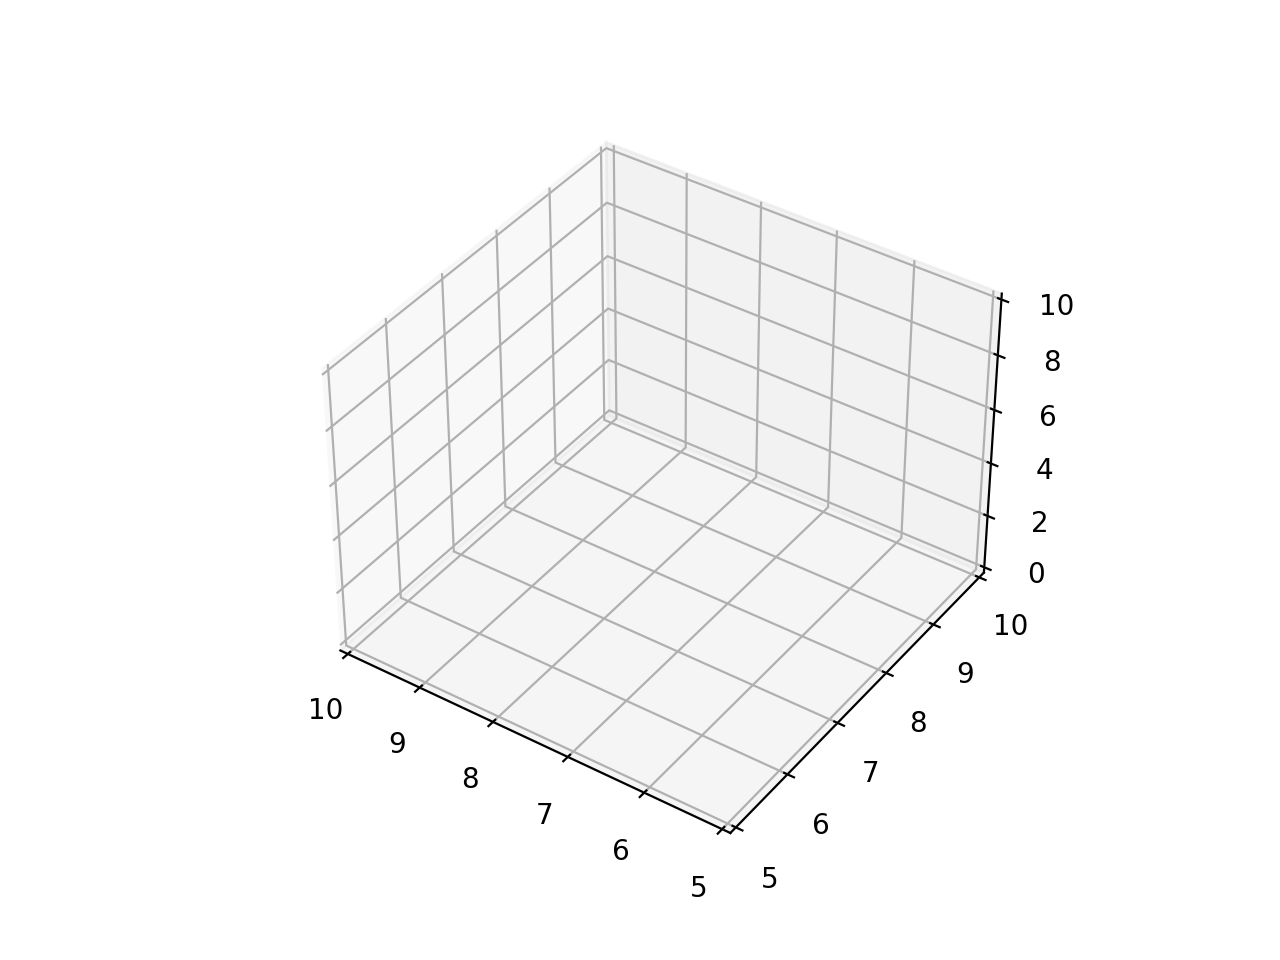

In [12]:
%matplotlib notebook

# Adapted from
# https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

##############################################################
#The creation of my figure                                   #
fig = plt.figure()                                           #
ax = fig.add_subplot(111, projection='3d')                   #
#Creating a global variable scat to store particle positions #
scat = ax.scatter([], [], [])                                #
##############################################################

my_timer = 0 
dt = 0.01

def init():
    """
    Creates my starting particle positions on the graph
    """
    ax.clear()
    ax.set_xlim3d([5, 10])
    ax.invert_xaxis()
    ax.set_ylim3d([5, 10])
    ax.set_zlim3d([0, 10])
    scat = ax.scatter(
        [particle[0] for particle in table[my_timer]],
        [particle[1] for particle in table[my_timer]],
        [particle[2] for particle in table[my_timer]]
    )
    return scat,

def animate(frame):
    global my_timer, dt
    scat._offsets3d = (
        [particle[0] for particle in table[my_timer]],
        [particle[1] for particle in table[my_timer]],
        [particle[2] for particle in table[my_timer]]
    )
    my_timer += dt
    return scat,

#Interval here delays the time per frame shown
ani = FuncAnimation(fig, animate, frames=duration, init_func=init, blit=False, interval = 250)
plt.show()